In [1]:
import numpy as np

import matplotlib.pyplot as plt

from data_retrieval import seizure_timestamps, classify, seizurevector_retrieval

from nonseizure_dataretrieval import non_seizure_retrieval

In [2]:
with open('../chbmit/1.0.0/RECORDS', 'r') as f:
    recordlines = f.readlines()
    recordlines = [line[6:].strip() for line in recordlines]
    
with open('../chbmit/1.0.0/RECORDS-WITH-SEIZURES', 'r') as f:
    seizurelines = f.readlines()
    seizurelines = [line[6:].strip() for line in seizurelines]
    
summaries = []
for x in range(1, 25):
    if x < 10:
        x = f'0{x}'
    with open(f'../chbmit/1.0.0/chb{x}/chb{x}-summary.txt', 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines[29:]]
        summaries += lines

In [3]:
timestamps = seizure_timestamps(summaries, seizurelines)

In [4]:
seizureclass = np.zeros((197, 100))

In [322]:
Y = classify(seizureclass, timestamps)

In [6]:
X, classifierpop = seizurevector_retrieval(timestamps, channel1=0, channel2=3)

 44%|████▍     | 62/141 [01:28<03:20,  2.54s/it]

61
index 927744 is out of bounds for axis 1 with size 927744


 96%|█████████▋| 136/141 [03:07<00:05,  1.01s/it]

135
index 921600 is out of bounds for axis 1 with size 921600


 99%|█████████▊| 139/141 [03:09<00:01,  1.29it/s]

138
index 921600 is out of bounds for axis 1 with size 921600


 99%|█████████▉| 140/141 [03:09<00:00,  1.58it/s]

139
index 921600 is out of bounds for axis 1 with size 921600


100%|██████████| 141/141 [03:10<00:00,  1.35s/it]


In [323]:
classifierpop

[61, 135, 138, 139]

In [324]:
Y = np.delete(Y, classifierpop, axis=0)

In [8]:
path = 'nonseizure.csv'
X_noseize, _ = non_seizure_retrieval(recordlines, seizurelines, i1=0, i2=3)

  8%|▊         | 42/545 [00:39<06:19,  1.32it/s]

41
index 921600 is out of bounds for axis 1 with size 921600


  9%|▉         | 51/545 [00:46<06:13,  1.32it/s]

50
index 921600 is out of bounds for axis 1 with size 921600


 15%|█▍        | 81/545 [01:15<06:01,  1.28it/s]

80
index 921600 is out of bounds for axis 1 with size 921600


 39%|███▉      | 212/545 [04:12<04:11,  1.32it/s]

211
index 921600 is out of bounds for axis 1 with size 921600


 47%|████▋     | 258/545 [05:14<03:55,  1.22it/s]

257
index 921600 is out of bounds for axis 1 with size 921600


 53%|█████▎    | 291/545 [05:46<03:28,  1.22it/s]

290
index 921600 is out of bounds for axis 1 with size 921600


 54%|█████▎    | 292/545 [05:47<02:53,  1.46it/s]

291
index 921600 is out of bounds for axis 1 with size 921600


 54%|█████▍    | 294/545 [05:48<02:40,  1.56it/s]

293
index 921600 is out of bounds for axis 1 with size 921600


 61%|██████    | 333/545 [06:25<02:54,  1.22it/s]

332
index 921600 is out of bounds for axis 1 with size 921600


 63%|██████▎   | 344/545 [06:37<03:07,  1.07it/s]

343
index 921600 is out of bounds for axis 1 with size 921600


 70%|███████   | 384/545 [07:18<02:10,  1.24it/s]

383
index 921600 is out of bounds for axis 1 with size 921600


 78%|███████▊  | 423/545 [07:56<01:36,  1.26it/s]

422
index 921600 is out of bounds for axis 1 with size 921600


 99%|█████████▉| 541/545 [09:57<00:03,  1.23it/s]

540
index 921600 is out of bounds for axis 1 with size 921600


100%|██████████| 545/545 [10:01<00:00,  1.10s/it]


In [325]:
# Use for debugging purposes
"""X_copy = X[:]
newX = np.ones((193, 100, 184))
for index, val in enumerate(X_copy):
    newX[index] = val"""
# classifierpop = [x for x in classifierpop if x < 197]

# X_copy = X[:]
# Y_copy = Y[:]
# X = X_copy[:]
# Y.shape

In [327]:
X = np.concatenate((X, X_noseize[0:30]))
classify_noseize = np.zeros((30, 100))
# classify_noseize = np.delete(classify_noseize, classifierpop, axis=0)
Y = np.concatenate((Y, classify_noseize))

In [328]:
print(f'Logits Shape: {X.shape}, Labels Shape: {Y.shape}')

Logits Shape: (223, 100, 24), Labels Shape: (223, 100)


In [302]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, AveragePooling1D, Dense, BatchNormalization, SimpleRNN, Dropout, LSTM, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
from keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives

In [256]:
# Our custom loss' wrapper
def custom_loss(recall_weight, spec_weight):

    def recall_spec_loss(y_true, y_pred):
        return binary_recall_specificity(y_true, y_pred, recall_weight, spec_weight)

    # Returns the (y_true, y_pred) loss function
    return recall_spec_loss

In [163]:
def search_create_RNN(hp, hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # model.add(BatchNormalization())
    model.add(LSTM(hidden_units, activation=hp.Choice('LSTM1Activation', ['relu', 'tanh', 'sigmoid', 'softmax', 'elu', 'softplus', 'softsign', 'selu']), return_sequences=True))
    model.add(LSTM(hidden_units, activation=hp.Choice('LSTM2Activation', ['relu', 'tanh', 'sigmoid', 'softmax', 'elu', 'softplus', 'softsign', 'selu']), return_sequences=True))
    model.add(AveragePooling1D(pool_size=100))
    model.add(Dropout(hp.Float('DropoutRate1', 0, 0.99, step=0.1)))
    model.add(Dense(units=dense_units, activation=hp.Choice('Dense1Activation', ['relu', 'tanh', 'sigmoid', 'softmax', 'elu', 'softplus', 'softsign', 'selu'])))
    model.add(LeakyReLU())
    model.add(Dense(units=dense_units, activation=activation[2]))
    model.add(tf.keras.layers.Reshape((100,)))
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['BinaryAccuracy'])
    return model

In [257]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # model.add(BatchNormalization())
    model.add(LSTM(hidden_units, activation=activation[0], return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[0], return_sequences=True))
    model.add(AveragePooling1D(pool_size=100))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.add(LeakyReLU())
    model.add(Dense(units=dense_units, activation=activation[2]))
    model.add(tf.keras.layers.Reshape((100,)))
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-2,
    decay_steps=20000)
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['BinaryAccuracy', 'Recall', 'Precision'])
    return model

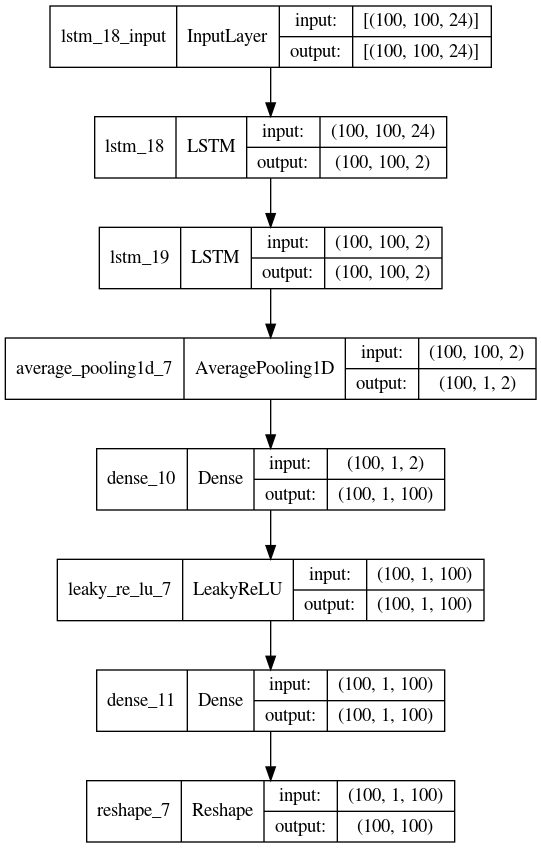

In [167]:
n_samples = 10
n_timesteps = 100
n_features = 3 * 8
model = create_RNN(2, n_timesteps, (n_timesteps, n_features), activation=['tanh', 'tanh', 'sigmoid'])
model.build((n_timesteps, n_timesteps, n_features))
tf.keras.utils.plot_model(model, show_shapes=True)

In [329]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20, shuffle=True)

In [53]:
import keras_tuner as kt

def build_model(hp):
    return create_RNN(hp, 2, n_timesteps, (n_timesteps, n_features), activation=['tanh', 'tanh', 'sigmoid'])

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="binary_accuracy",
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search(X_train, Y_train, epochs=2, validation_data=(X_test,Y_test))

TypeError: create_RNN() got multiple values for argument 'activation'

In [134]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.01)
earlystop = EarlyStopping(monitor='loss', patience=10, min_delta=0.0001)
history = model.fit(X_train, Y_train, epochs=100, batch_size=256,verbose=2)

Epoch 1/100
2/2 - 4s - loss: 0.6934 - binary_accuracy: 0.4409 - recall: 0.1195 - precision: 0.3846 - 4s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.6931 - binary_accuracy: 0.5043 - recall: 0.7480 - precision: 0.5173 - 178ms/epoch - 89ms/step
Epoch 3/100
2/2 - 0s - loss: 0.6930 - binary_accuracy: 0.5174 - recall: 0.8857 - precision: 0.5221 - 180ms/epoch - 90ms/step
Epoch 4/100
2/2 - 0s - loss: 0.6927 - binary_accuracy: 0.5215 - recall: 0.9759 - precision: 0.5222 - 178ms/epoch - 89ms/step
Epoch 5/100
2/2 - 0s - loss: 0.6925 - binary_accuracy: 0.5217 - recall: 1.0000 - precision: 0.5217 - 177ms/epoch - 88ms/step
Epoch 6/100
2/2 - 0s - loss: 0.6924 - binary_accuracy: 0.5217 - recall: 1.0000 - precision: 0.5217 - 178ms/epoch - 89ms/step
Epoch 7/100
2/2 - 0s - loss: 0.6924 - binary_accuracy: 0.5217 - recall: 1.0000 - precision: 0.5217 - 183ms/epoch - 91ms/step
Epoch 8/100
2/2 - 0s - loss: 0.6923 - binary_accuracy: 0.5217 - recall: 1.0000 - precision: 0.5217 - 185ms/epoch - 93ms/step
Epoch

Text(0.5, 0, 'Epochs')

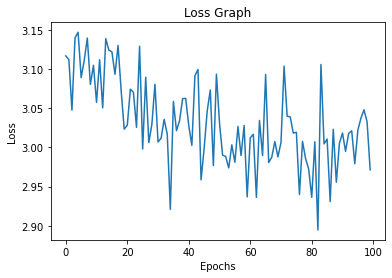

In [344]:
plt.plot(history.history['loss'])

plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [258]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape

def create_test(activation, dense_units):
    # define model
    model = Sequential()
    model.add(LSTM(2, activation=activation[0], return_sequences=True))
    model.add(LSTM(2, activation=activation[0], return_sequences=True))
    model.add(LSTM(2, activation=activation[0], return_sequences=True))
    model.add(AveragePooling1D(pool_size=100))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.add(LeakyReLU())
    model.add(Reshape((100,)))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['BinaryAccuracy', 'Recall', 'Precision'])
    return model
    

n_samples = 10
n_timesteps = 100
n_features = 3 * 8
model = create_test(['tanh', 'sigmoid'], n_timesteps)
model.build((n_timesteps, n_timesteps, n_features))
# tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, Y_train, epochs=100, verbose=2)

Epoch 1/100
6/6 - 6s - loss: 0.6921 - binary_accuracy: 0.6696 - recall: 0.7087 - precision: 0.8932 - 6s/epoch - 997ms/step
Epoch 2/100
6/6 - 0s - loss: 0.6895 - binary_accuracy: 0.7651 - recall: 0.8500 - precision: 0.8787 - 398ms/epoch - 66ms/step
Epoch 3/100
6/6 - 0s - loss: 0.6867 - binary_accuracy: 0.7683 - recall: 0.8544 - precision: 0.8785 - 388ms/epoch - 65ms/step
Epoch 4/100
6/6 - 0s - loss: 0.6835 - binary_accuracy: 0.7789 - recall: 0.8682 - precision: 0.8787 - 413ms/epoch - 69ms/step
Epoch 5/100
6/6 - 0s - loss: 0.6800 - binary_accuracy: 0.7867 - recall: 0.8789 - precision: 0.8784 - 419ms/epoch - 70ms/step
Epoch 6/100
6/6 - 0s - loss: 0.6761 - binary_accuracy: 0.8105 - recall: 0.9100 - precision: 0.8787 - 393ms/epoch - 66ms/step
Epoch 7/100
6/6 - 0s - loss: 0.6718 - binary_accuracy: 0.8126 - recall: 0.9128 - precision: 0.8787 - 402ms/epoch - 67ms/step
Epoch 8/100
6/6 - 0s - loss: 0.6672 - binary_accuracy: 0.8258 - recall: 0.9301 - precision: 0.8788 - 404ms/epoch - 67ms/step
Ep

In [308]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, RocCurveDisplay, roc_curve
import tensorflow as tf

In [333]:
ypred = model.predict(X_test)
ypred

array([[0.6985147 , 0.69064957, 0.7048837 , ..., 0.700266  , 0.6973977 ,
        0.69440496],
       [0.6985147 , 0.69064957, 0.7048837 , ..., 0.700266  , 0.6973977 ,
        0.69440496],
       [0.6985147 , 0.69064957, 0.7048837 , ..., 0.700266  , 0.6973977 ,
        0.69440496],
       ...,
       [0.6985147 , 0.69064957, 0.7048837 , ..., 0.700266  , 0.6973977 ,
        0.69440496],
       [0.6985147 , 0.69064957, 0.7048837 , ..., 0.700266  , 0.6973977 ,
        0.69440496],
       [0.6985147 , 0.69064957, 0.7048837 , ..., 0.700266  , 0.6973977 ,
        0.69440496]], dtype=float32)

In [334]:
scaler = MinMaxScaler()
ypred = scaler.fit_transform(ypred.reshape(-1,1))

In [335]:
ypred = np.float64((ypred > 0.5))
print(ypred.shape)

(4500, 1)


In [336]:
cf_matrix = confusion_matrix(Y_test.reshape(-1,1), ypred)

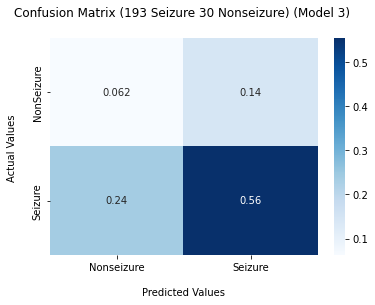

In [338]:
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix (193 Seizure 30 Nonseizure) (Model 3) \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values \n ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nonseizure','Seizure'])
ax.yaxis.set_ticklabels(['NonSeizure','Seizure'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [339]:
targetnames = ['NonSeizure', 'Seizure']
creport = classification_report( Y_test.reshape(-1,1), ypred, target_names=targetnames)

In [340]:
print(creport)

              precision    recall  f1-score   support

  NonSeizure       0.21      0.30      0.25       931
     Seizure       0.79      0.70      0.74      3569

    accuracy                           0.62      4500
   macro avg       0.50      0.50      0.49      4500
weighted avg       0.67      0.62      0.64      4500



In [341]:
fpr, tpr, thresholds = roc_curve(Y_test.reshape(-1,1), ypred)

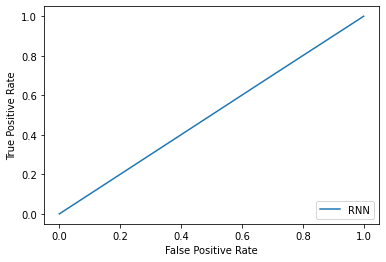

In [342]:
display = RocCurveDisplay(fpr=fpr,tpr=tpr, estimator_name='RNN')
display.plot()

In [343]:
tn, fp, fn, tp = confusion_matrix(Y_test.reshape(-1,1), ypred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
precision = tp / (tp+fp)
recall = tn / (tn+fn)
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Sensitivity: 0.7001961333706921
Specificity: 0.3007518796992481
Precision: 0.7933333333333333
Recall: 0.2074074074074074


# NOTES

- You're getting high accuracy when detecting seizures. However, there is a large amount of False Positives which limits usability

In [330]:
def RNNsimple(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.add(Dropout(0.2))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy', 'TruePositives', 'FalsePositives', 'Precision', 'Recall'])
    return model

In [331]:
n_samples = 10
n_timesteps = 100
n_features = 3 * 8
model = RNNsimple(2, n_timesteps, (n_timesteps, n_features), activation=['tanh', 'sigmoid'])

In [332]:
history = model.fit(X_train, Y_train, epochs=100, verbose=2)

Epoch 1/100
6/6 - 1s - loss: 3.1171 - binary_accuracy: 0.7285 - true_positives: 12535.0000 - false_positives: 1727.0000 - precision: 0.8789 - recall: 0.8014 - 1s/epoch - 202ms/step
Epoch 2/100
6/6 - 0s - loss: 3.1124 - binary_accuracy: 0.7298 - true_positives: 12537.0000 - false_positives: 1706.0000 - precision: 0.8802 - recall: 0.8015 - 71ms/epoch - 12ms/step
Epoch 3/100
6/6 - 0s - loss: 3.0477 - binary_accuracy: 0.7325 - true_positives: 12613.0000 - false_positives: 1734.0000 - precision: 0.8791 - recall: 0.8064 - 76ms/epoch - 13ms/step
Epoch 4/100
6/6 - 0s - loss: 3.1403 - binary_accuracy: 0.7266 - true_positives: 12498.0000 - false_positives: 1724.0000 - precision: 0.8788 - recall: 0.7991 - 65ms/epoch - 11ms/step
Epoch 5/100
6/6 - 0s - loss: 3.1473 - binary_accuracy: 0.7265 - true_positives: 12484.0000 - false_positives: 1711.0000 - precision: 0.8795 - recall: 0.7982 - 69ms/epoch - 11ms/step
Epoch 6/100
6/6 - 0s - loss: 3.0893 - binary_accuracy: 0.7284 - true_positives: 12551.0000 

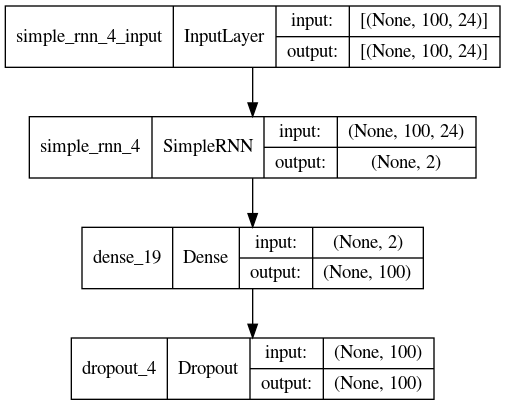

In [345]:
tf.keras.utils.plot_model(model, show_shapes=True)